# AE 370 Code document

Let's define the equations of motion and the Runge-Kutta 4th order numerical method (RK4) as a function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Constants (arbitrary values for testing)
m1, m2 = 1.0, 1.0  # masses
l1, l2 = 1.0, 1.0  # lengths
g = 9.81           # gravity

def equations(t, y):
    theta1, omega1, theta2, omega2 = y
    delta = theta2 - theta1
    sin_delta = np.sin(delta)
    cos_delta = np.cos(delta)
    sin_theta1 = np.sin(theta1)
    sin_theta2 = np.sin(theta2)

    denom = l1 * (m1 + m2 * sin_delta**2)

    ddtheta1 = (
        -sin_delta * (m2 * l1 * omega1**2 * cos_delta + m2 * l2 * omega2**2)
        - g * ((m1 + m2) * sin_theta1 - m2 * sin_theta2 * cos_delta)
    ) / denom

    ddtheta2 = (
        sin_delta * ((m1 + m2) * l1 * omega1**2 + m2 * l2 * omega2**2 * cos_delta)
        + g * ((m1 + m2) * sin_theta1 * cos_delta - (m1 + m2) * sin_theta2)
    ) / denom

    return np.array([omega1, ddtheta1, omega2, ddtheta2])

def rk4_step(f, t, y, dt):
    k1 = dt * f(t, y)
    k2 = dt * f(t + dt / 2, y + k1 / 2)
    k3 = dt * f(t + dt / 2, y + k2 / 2)
    k4 = dt * f(t + dt, y + k3)
    return y + (k1 + 2 * k2 + 2 * k3 + k4) / 6

def solve_rk4(y0, dt, t_max):
    t_values = np.arange(0, t_max, dt)
    y_values = np.zeros((len(t_values), len(y0)))
    y_values[0] = y0 

    for i in range(1, len(t_values)):
        y_values[i] = rk4_step(equations, t_values[i-1], y_values[i-1], dt)

    return t_values, y_values

## Error and State Analyis

Set ```reduce_analysis``` to ```False``` to run the full analysis, otherwise a reduced resolution one will run.

In [2]:
reduce_analysis = True

In [3]:
def compare_full_state_error(y0, t_max, dt_list, t_ref, y_ref):
    """Since no know analytical solution exists for the double pendulum system,
    we must use a much more accurate numerical approximation to get our reference solution.
    This leads to an issue where gaps in the reference solution exists.
    To overcome this, when there is no exact reference point avaiable to compare to,
    one is interpolated from the known reference solution."""
    
    interp_ref = interp1d(t_ref, y_ref, axis=0, kind='cubic')

    errors = []

    for dt in dt_list:
        t_test = np.arange(0, t_max, dt)
        t_test, y_test = solve_rk4(y0, dt, t_max)
        
        # Interpolate reference to match test time points
        y_ref_interp = interp_ref(t_test)
        error = np.linalg.norm(y_test - y_ref_interp, axis=1)  # norm at each time step
        mean_error = np.mean(error)  # average over the trajectory
        errors.append(mean_error)

    # Create and align reference line
    x_anchor = dt_list[-2]
    y_anchor = errors[-2]
    ref_error_x = np.array(dt_list)
    ref_error_y = (ref_error_x / x_anchor)**4 * y_anchor

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.loglog(ref_error_x, ref_error_y, '--', label='Reference Slope $O(dt^4)$')
    plt.loglog(dt_list, errors, 'o-', label="RK4 Error")
    plt.xlabel("Time Step (dt)")
    plt.ylabel("Mean Full State Error (2-norm)")
    plt.title("Error vs Time Step for RK4")
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.show()


Compute the reference soultion.

In [7]:
# Time parameters
t_max = 10  # simulation time in seconds
dt_rk4 = 0.01  # RK4 time step

# Initial conditions: [theta1, omega1, theta2, omega2]
y0 = np.array([np.pi / 4, 0, np.pi / 2, 0])

# Reference solution time step
if reduce_analysis:
    dt_ref = .0001
else:
    dt_ref = 0.00001

t_ref, y_ref = solve_rk4(y0, dt_ref, t_max)

Compute the error reduction as dt decreases.

C:\Users\jelly\AppData\Local\Temp\ipykernel_14244\1084499320.py:21: RuntimeWarning: overflow encountered in scalar power
  -sin_delta * (m2 * l1 * omega1**2 * cos_delta + m2 * l2 * omega2**2)
C:\Users\jelly\AppData\Local\Temp\ipykernel_14244\1084499320.py:21: RuntimeWarning: invalid value encountered in scalar add
  -sin_delta * (m2 * l1 * omega1**2 * cos_delta + m2 * l2 * omega2**2)
C:\Users\jelly\AppData\Local\Temp\ipykernel_14244\1084499320.py:26: RuntimeWarning: overflow encountered in scalar power
  sin_delta * ((m1 + m2) * l1 * omega1**2 + m2 * l2 * omega2**2 * cos_delta)
C:\Users\jelly\AppData\Local\Temp\ipykernel_14244\1084499320.py:26: RuntimeWarning: invalid value encountered in scalar add
  sin_delta * ((m1 + m2) * l1 * omega1**2 + m2 * l2 * omega2**2 * cos_delta)


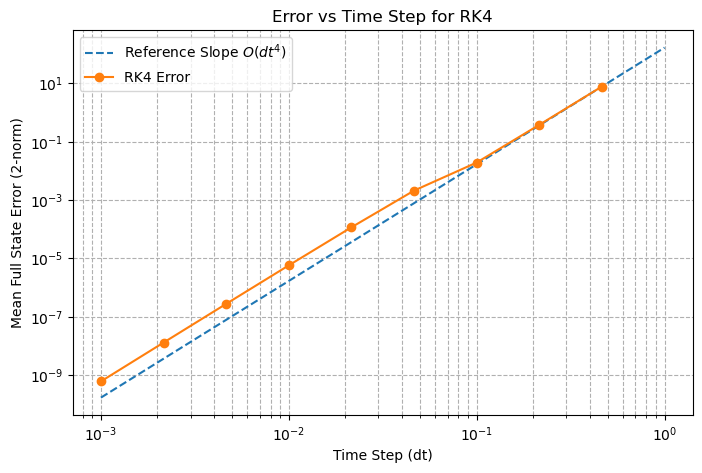

In [8]:
if reduce_analysis:
    dt_values = np.logspace(-3,0,10)
else:
    dt_values = np.logspace(-4, 0, 15)
compare_full_state_error(y0, t_max, dt_values, t_ref, y_ref)

## Plot the etate error for on time step

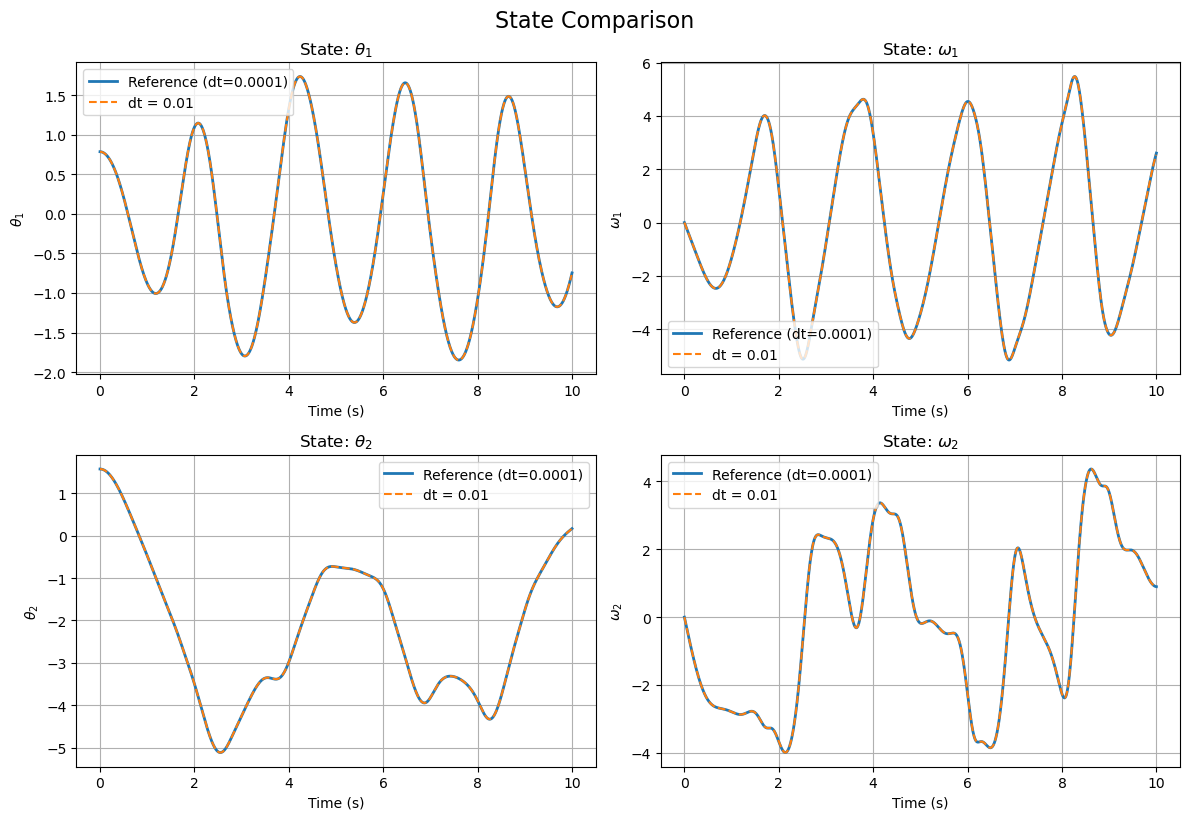

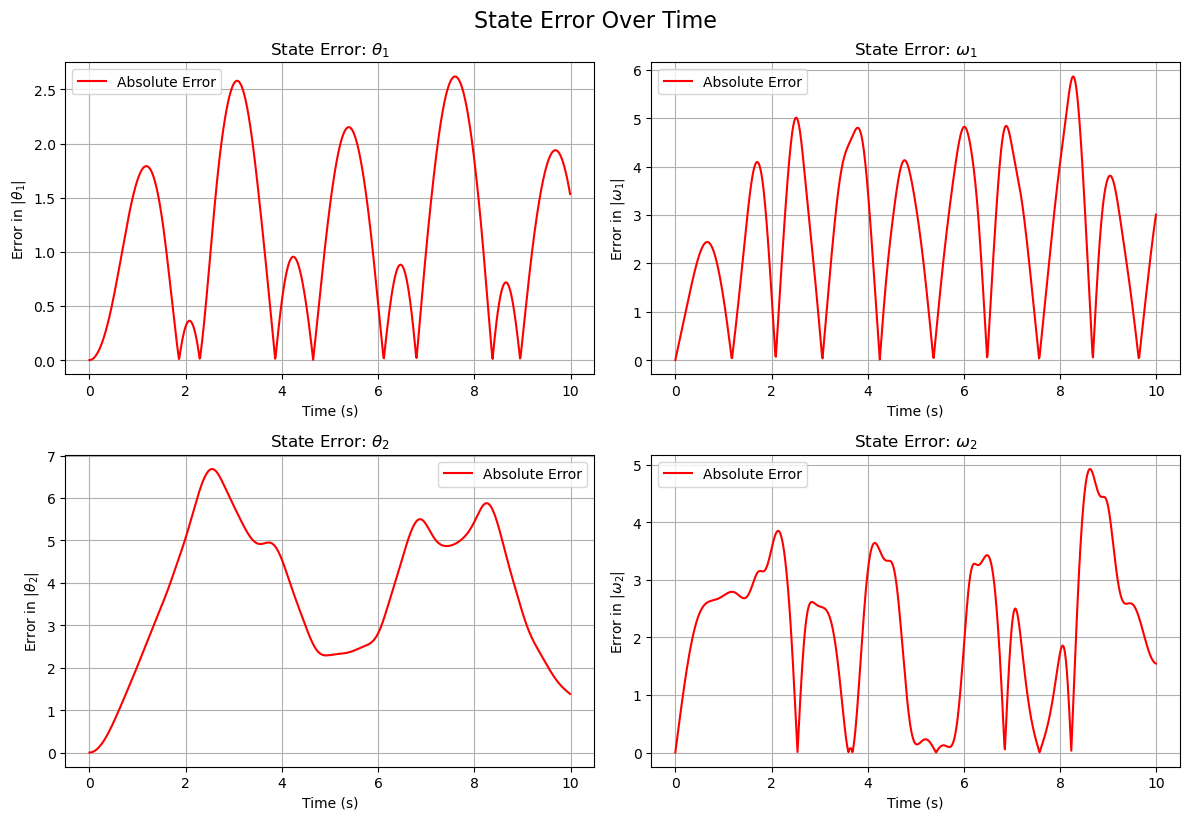

In [10]:
dt_n = 0.01  # Compairsion dt

t_n, y_n = solve_rk4(y0, dt_n, t_max)

# Plot the state variables
labels = [r'$\theta_1$', r'$\omega_1$', r'$\theta_2$', r'$\omega_2$']
plt.figure(figsize=(12, 8))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(t_ref, y_ref[:, i], label='Reference (dt=0.0001)', linewidth=2)
    plt.plot(t_n, y_n[:, i], '--', label=f'dt = {dt_n}', linewidth=1.5)
    plt.xlabel('Time (s)')
    plt.ylabel(labels[i])
    plt.title(f'State: {labels[i]}')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle('State Comparison', fontsize=16, y=1.02)
plt.show()

# Plot error
min_len = min(len(t_ref), len(t_n))
t_error = t_n[:min_len]
errors = np.abs(y_n[:min_len] - y_ref[:min_len])

plt.figure(figsize=(12, 8))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(t_error, errors[:, i], color='red', label='Absolute Error')
    plt.xlabel('Time (s)')
    plt.ylabel(f'Error in |{labels[i]}|')
    plt.title(f'State Error: {labels[i]}')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle('State Error Over Time', fontsize=16, y=1.02)
plt.show()
